In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import pickle
import time
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/theodoraworledge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# choose dataset
result_tag = '_cleaned_minus_one_coverage_UF.csv'

dataset_str_ls = ['NQ', 'Eta3G', 'MH', 'MASH']
ops = ['Snippet', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive', 'Gemini', 'Post Hoc']
all_ops = ['Snippet', 'Quoted', 'Quoted Reeval', 'Paraphrased', 'Entailed', 'Abstractive', 'Gemini', 'Post Hoc']
op_fps = {'NQ': '../mturk_results/nq_mturk_with_needs_citation_labels2',
       'MH': '../mturk_results/mh_mturk_with_needs_citation_labels',
       'MASH': '../mturk_results/mash_mturk_with_needs_citation_labels',
       'Eta3G': '../mturk_results/eli3_mturk_with_needs_citation_labels',
      }
baseline_fps = {'NQ': '../mturk_results/nq_baseline_mturk_with_needs_citation_labels',
       'MH': '../mturk_results/mh_baseline_mturk_with_needs_citation_labels',
       'MASH': '../mturk_results/mash_baseline_mturk_with_needs_citation_labels',
       'Eta3G': '../mturk_results/eli3_baseline_mturk_with_needs_citation_labels',
      }
results_by_dataset = {}
for k in op_fps.keys():
    op_df = pd.read_csv(op_fps[k]+result_tag, index_col=False)
    baseline_df = pd.read_csv(baseline_fps[k]+'.csv', index_col=False)
    
    # rename the reeval quoted op for the outputs
    baseline_df_outputs_no_quoted = baseline_df[baseline_df['op']!='Quoted']
    baseline_df_outputs_quoted = baseline_df[baseline_df['op']=='Quoted']
    baseline_df_outputs_quoted.loc[:,'op'] = ['Quoted Reeval']*len(baseline_df_outputs_quoted)
    baseline_df = pd.concat([baseline_df_outputs_no_quoted, baseline_df_outputs_quoted])
    
    dataset_results = pd.concat([op_df, baseline_df])
    results_by_dataset[k] = dataset_results
    
# Trim to 120 queries per OP per dataset
n_to_keep = 120
for dataset in dataset_str_ls:
    new_dataset_results = pd.DataFrame()
    dataset_results = results_by_dataset[dataset]
    for op in all_ops:
        dataset_op_results = dataset_results[dataset_results['op']==op]
        dataset_op_results = dataset_op_results.sort_values('query_id')
        dataset_op_results = dataset_op_results.iloc[:120]
        new_dataset_results = pd.concat([new_dataset_results, dataset_op_results], ignore_index=True)
    results_by_dataset[dataset] = new_dataset_results

for dataset in dataset_str_ls:
    assert len(results_by_dataset[dataset]) == n_to_keep*len(all_ops)
    
assert len(results_by_dataset) == 4

In [4]:
dataset = 'NQ'
results = results_by_dataset[dataset]
for i in range(len(results)):
    question = results['Question'].iloc[i]
    if (question != "when did the united kingdom entered world war 2"):
        continue
    print('~~~~~~~~~~~~~~~~~~~~~~ OP:\n', results['op'].iloc[i])
    print('QUESTION:', question)
    print()
    print('OUTPUT:\n', results['Output (cited)'].iloc[i])
    print()
    print()
    print('SOURCES:\n', results['All Sources'].iloc[i])
    print()
    print()
    print()
    print()
    

~~~~~~~~~~~~~~~~~~~~~~ OP:
 Quoted
QUESTION: when did the united kingdom entered world war 2

OUTPUT:
 "At 11:15 a.m" [1]. "British Standard Time (BST) the Prime Minister Neville Chamberlain announces to the public that Britain is at war with Germany" [2].


SOURCES:
 ["This is a timeline of events of World War II in 1939 from the start of the war on 1 September 1939. For events preceding September 1, 1939, see the timeline of events preceding World War II. Germany's invasion of Poland on 1 September 1939 brought many countries into the war. This event, and the declaration of war by France and Britain two days later, mark the beginning of World War II. After the declaration of war, Western Europe saw minimal land and air warfare, leading to this time period being termed the 'Phoney War'. At sea, this time period saw the opening stages of the Battle of the Atlantic. In eastern Europe, however, the agreement between the Soviet Union and Nazi Germany signed on 23 August opened the way in 

Table for overall abstention rate and abstention type rates (denominator is total number of generations)

Plot:\
The y axis will be [0,1]\
The x axis will be categorical with Snippet, Quoted-Abstractive, GPT-4 + Post Hoc citations, Gemini

# Identify the abstention rates for our OPs

Used unrecorded_query_ids to rerun the failed instances with failure tracking. See the section below for failure type classification and analysis.

In [5]:
for dataset in dataset_str_ls:
    dataset_results = results_by_dataset[dataset]
    baseline_results = dataset_results[dataset_results['op'].isin(['Snippet', 'Quoted', 'Paraphrased', 'Entailed', 'Abstractive'])]
    
    unique_query_ids = np.unique(baseline_results['query_id'])
    sorted_unique_query_ids = np.sort(unique_query_ids)
    unrecorded_query_ids = []
    
    # iterate over all values of query_ids spanned by the actual annotated query_ids
    
    for i in range(sorted_unique_query_ids[0], sorted_unique_query_ids[-1]+1):
        if (i not in sorted_unique_query_ids):
            unrecorded_query_ids.append(i)
    print(dataset)
    print((sorted_unique_query_ids[0], sorted_unique_query_ids[-1]+1))
    print('Our OP Abstention rate:', len(unrecorded_query_ids) / (sorted_unique_query_ids[-1]+1 - sorted_unique_query_ids[0]))
    print()

NQ
(241, 412)
Our OP Abstention rate: 0.13450292397660818

Eta3G
(441, 595)
Our OP Abstention rate: 0.11688311688311688

MH
(61, 208)
Our OP Abstention rate: 0.013605442176870748

MASH
(60, 199)
Our OP Abstention rate: 0.0



# Classify the generation failures into retrieval and true generation failures
Examine the sources to determine whether the answer existed in the retrieval or not.

To Do:
- classify, and edit the failure dfs, save as new dfs
- add into our OP results df

To Do (standardized):
- get the failure AND failure type rates for these new our OP dfs
- use the same code to get the failure AND failure type rates for the baseline dfs
- decide whether to present on aggregate, by gold/retrieved dataset, or by dataset. Probably on aggregate in the main body and by dataset in the appendix with comments about gold/retrieved

In [8]:
# Address the logging that tracked retrieval failures as generation failures
def fix_retrieval_logging(results):
    for i in range(len(results)):
        if ((results['Abstention Type'].iloc[i]=='Generation Failure') and (len(results['All Sources'].iloc[i])==0)):
            results.loc[i, "Abstention Type"] = 'Retrieval Failure'
    return results
    
abstention_recovery_fps = {
        'Eta3G': '../generation_results/abstention_recovery_eli3',
        'MH': '../generation_results/abstention_recovery_mh',
        'NQ': '../generation_results/abstention_recovery_nq',
      }
for k in abstention_recovery_fps.keys():
    print('Generation failures for:', k)
    print()
    results = pd.read_json(abstention_recovery_fps[k]+'.jsonl', lines=True)
    missing_from_mturk_eval = np.unique(results['ID'])
    results = fix_retrieval_logging(results)
    generation_failure_results = results[results['Abstention Type']=='Generation Failure']
    for i in range(len(generation_failure_results)):
        print(generation_failure_results['ID'].iloc[i])
        print(generation_failure_results['Question'].iloc[i])
        print(generation_failure_results['Quoted Output'].iloc[i])
        print()
        sources = generation_failure_results['All Sources'].iloc[i]
        for s in sources:
            print(s)
            print()
        urls = generation_failure_results['All URLs'].iloc[i]
        for s in urls:
            print(s)
            print()
        print(generation_failure_results['ID'].iloc[i])
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('----------   ----------   ----------   ----------   ----------   ----------   ----------')
    

Generation failures for: Eta3G

451
Explain to a third-grader: who is the current defence against the dark arts teacher
Insufficient information to generate a grounded response.

Defence Against the Dark Arts (abbreviated as DADA) was a subject and core class taught at Hogwarts School of Witchcraft and Wizardry and Ilvermorny School of Witchcraft and Wizardry[16][27] in which students studied and learnt how to defend themselves against all aspects of the Dark Arts, including dark creatures,[24][28][29] curses, hexes and jinxes (dark charms),[25] and duelling.[23] The position of Defence Against the Dark Arts professor at the school was once rumoured to be jinxed, as no teacher could hold the post for more than a year without suffering an unpleasant fate. Tom Riddle jinxed the position because Albus Dumbledore did not give him the job when he applied for it.[4] The fact that no teacher has lasted longer than a year meant that the subject had numerous Professors over the years.[23] Ilver

In [9]:
# For each dataset, list the query IDs that should be categorized as retrieval failures. Currently, they are all listed as generation failures
ids_to_fix_as_retrieval_failures = {
    'NQ': [259, 277, 376, 381,],
    'MH': [],
    'Eta3G': [451, 511, 537, 555, 581, 590],
    'MASH': []
}

# Update the failure category of certain query_ids to Retrieval Failure
def fix_abstention_type_to_retrieval(results, ids_to_fix):
    for query_id in ids_to_fix:
        results.loc[results["ID"] == query_id, 'Abstention Type'] = 'Retrieval Failure'
    return results


# update the failure categories with the hand-annotated failure categories
# save as new json files!
for k in abstention_recovery_fps.keys():
    ids_to_fix = ids_to_fix_as_retrieval_failures[k]
    results = pd.read_json(abstention_recovery_fps[k]+'.jsonl', lines=True)
    results = fix_retrieval_logging(results)
    results = fix_abstention_type_to_retrieval(results, ids_to_fix)
    results.to_csv(abstention_recovery_fps[k]+'hand_categorized.csv')

# Merge hand-annotated failure categories for our OPs into the json files of results
These are the files from which the mturk inputs are generated.
Also, trim them to be consistent with range in which the 120 samples annotated via mturk exist.

If a query was originally abstained but is no longer abstained, then replace the row if it exists, or just add the row.

Add the 'Abstention Type' column to all rows.

In [12]:
k = 'MH'

dataset_str_ls = ['NQ', 'Eta3G', 'MH', 'MASH']

op_original_generations = {'NQ': '../mturk_results/nq_mturk3',
       'MH': '../mturk_results/mh_mturk',
       'MASH': '../mturk_results/mash_mturk',
       'Eta3G': '../mturk_results/mturk_eli3',
      }

op_original_120_ranges = {'NQ': (241, 412),
       'MH': (61, 208),
       'MASH': (60, 199),
       'Eta3G': (441, 595)
      }

def add_recovered_abstentions(op_generations, recovered_abstentions):
    op_generations['Abstention Type'] = 'No Failure'
    for i in range(len(recovered_abstentions)):
        query_id = recovered_abstentions['ID'].iloc[i]
        if (query_id in list(op_generations['ID'])):
            correct_abstention_type = recovered_abstentions.loc[recovered_abstentions['ID'] == query_id, 'Abstention Type'].iloc[0]
            op_generations.loc[op_generations['ID'] == query_id, 'Abstention Type'] = correct_abstention_type
        else:
            op_generations = pd.concat([op_generations, recovered_abstentions.loc[recovered_abstentions['ID'] == query_id]])
    return op_generations

def annotate_insufficient_info_failures(op_generations, recorded_ids_to_fix_as_retrieval_failures_for_dataset):
    for i in range(len(op_generations)):
        if ('op' in op_generations.keys()):
            output_key = 'Output'
        else:
            output_key = 'Quoted Output'
        output = op_generations[output_key].iloc[i]
        if (('Insufficient information' in output) and ('op' not in op_generations.keys())):
            query_id = op_generations['ID'].iloc[i]
            if (query_id in recorded_ids_to_fix_as_retrieval_failures_for_dataset):
                op_generations.loc[i, 'Abstention Type'] = 'Retrieval Failure'
            else:
                op_generations.loc[i, 'Abstention Type'] = 'Generation Failure'
    return op_generations

op_generations_by_dataset = {}
op_recovered_abstentions_by_dataset = {}
for k in dataset_str_ls:
    df = pd.read_json(op_original_generations[k]+'.jsonl', lines=True)
    start_query_id, end_query_id = op_original_120_ranges[k]
    df = df[(df['ID']>=start_query_id)&(df['ID']<=end_query_id)] # trim to the range about the 120 annotated instances
    op_generations_by_dataset[k] = df
    if (k in abstention_recovery_fps):
        op_recovered_abstentions_by_dataset[k] = pd.read_csv(abstention_recovery_fps[k]+'hand_categorized.csv')

# add ID to list if the retrieved source does not contain the answer:
recorded_ids_to_fix_as_retrieval_failures = {
    'NQ': [291, 259, 410, 342, 374, 376, 268, 309, 270, 380, 381, 277, 278, 391, 371, 377],
    'MH': [],
    'Eta3G': [451, 511, 590, 537, 478, 555, 532, 581],
    'MASH': []
}

for k in dataset_str_ls:
    op_generations = op_generations_by_dataset[k]
    if (k in op_recovered_abstentions_by_dataset.keys()):
        recovered_abstentions = op_recovered_abstentions_by_dataset[k]
        op_generations = add_recovered_abstentions(op_generations, recovered_abstentions)
    else:
        op_generations['Abstention Type'] = 'No Failure'
    op_generations = annotate_insufficient_info_failures(op_generations, recorded_ids_to_fix_as_retrieval_failures[k])
    # save our OP baseline results with the recovered abstentions
    op_generations.to_csv(op_original_generations[k]+'_with_failures.jsonl')
    start_query_id, end_query_id = op_original_120_ranges[k]
    for i in range(start_query_id, end_query_id): # check that all queries are accounted for
        if (i not in list(op_generations['ID'])):
            assert False

# Load in the original generations for both OG and Baselines for all datasets. These files all have abstention tracking!
op_original_generations_with_failures = {}
for k in dataset_str_ls:
    df = pd.read_csv(op_original_generations[k]+'_with_failures.jsonl')
    op_original_generations_with_failures[k] = df

gemini_original_generations_with_failures = {
'NQ': pd.read_csv('../mturk_results/gemini_mturk_nq_241_200_0_205_byQueryGemini.csv', index_col=False),
'Eta3G': pd.read_csv('../mturk_results/gemini_mturk_eli3g_441_200_0_200_byQueryGemini.csv', index_col=False),
'MH': pd.read_csv('../mturk_results/gemini_mturk_mh_60_237_0_238_byQueryGemini.csv', index_col=False),
'MASH': pd.read_csv('../mturk_results/gemini_mturk_mash_60_200_0_177_byQueryGemini.csv', index_col=False)
}
post_hoc_original_generations_with_failures = {
'NQ': pd.read_csv('../mturk_results/post_hoc_mturk_nq_241_441_0_200_byQueryPostHoc.csv', index_col=False),
'Eta3G': pd.read_csv('../mturk_results/post_hoc_mturk_eli3g_0_200_byQueryPostHoc.csv', index_col=False),
'MH': pd.read_csv('../mturk_results/post_hoc_mturk_mh_0_201_byQueryPostHoc.csv', index_col=False),
'MASH': pd.read_csv('../mturk_results/post_hoc_mturk_mash_0_200_byQueryPostHoc.csv', index_col=False)
}

# Overall abstention rates by method
### Added to table

In [13]:
def print_abstention_rates(all_op_generation_results, all_baseline_generation_results, n):        
    # Overall snippet-abstractive abstention rate
    all_op_generation_results = all_op_generation_results.sample(n=n)
    num_op_abstentions = len(all_op_generation_results[all_op_generation_results['Abstention Type']!='No Failure'])
    percent_abstained = 100*len(all_op_generation_results[all_op_generation_results['Abstention Type']!='No Failure'])/len(all_op_generation_results)
    print('Reference OPs:', len(all_op_generation_results[all_op_generation_results['Abstention Type']!='No Failure']),' / ',len(all_op_generation_results))
    # print(percent_abstained)
    if (percent_abstained != 0):
        percent_retrieval_failure = len(all_op_generation_results[all_op_generation_results['Abstention Type']=='Retrieval Failure'])/num_op_abstentions
        percent_generation_failure = len(all_op_generation_results[all_op_generation_results['Abstention Type']=='Generation Failure'])/num_op_abstentions
        # retrieval_failure_rates_by_dataset.append(percent_retrieval_failure)
        # generation_failure_rates_by_dataset.append(percent_generation_failure)
        print('Post Hoc:', percent_generation_failure*100, percent_retrieval_failure*100)
    print()
    
    # Overall Post Hoc abstention rate
    all_post_hoc_baseline_generation_results = all_baseline_generation_results[all_baseline_generation_results['op']=='Post Hoc']
    all_post_hoc_baseline_generation_results = all_post_hoc_baseline_generation_results.sample(n=n)
    num_post_hoc_abstentions = len(all_post_hoc_baseline_generation_results[all_post_hoc_baseline_generation_results['Abstention Type']!='No Failure'])
    percent_abstained = 100*len(all_post_hoc_baseline_generation_results[all_post_hoc_baseline_generation_results['Abstention Type']!='No Failure'])/len(all_post_hoc_baseline_generation_results)
    print('Post Hoc:', len(all_post_hoc_baseline_generation_results[all_post_hoc_baseline_generation_results['Abstention Type']!='No Failure']),' / ',len(all_post_hoc_baseline_generation_results))
    # print(percent_abstained)
    if (percent_abstained != 0):
        percent_retrieval_failure = len(all_post_hoc_baseline_generation_results[all_post_hoc_baseline_generation_results['Abstention Type']=='Retrieval Failure'])/num_post_hoc_abstentions
        percent_generation_failure = len(all_post_hoc_baseline_generation_results[all_post_hoc_baseline_generation_results['Abstention Type']=='Generation Failure'])/num_post_hoc_abstentions
        # retrieval_failure_rates_by_dataset.append(percent_retrieval_failure)
        # generation_failure_rates_by_dataset.append(percent_generation_failure)
        print('Post Hoc:', percent_generation_failure*100, percent_retrieval_failure*100)
    print()
    
    # Overall Gemini abstention rate
    all_gemini_baseline_generation_results = all_baseline_generation_results[all_baseline_generation_results['op']=='Gemini']
    all_gemini_baseline_generation_results = all_gemini_baseline_generation_results.sample(n=n)
    num_gemini_abstentions = len(all_gemini_baseline_generation_results[all_gemini_baseline_generation_results['Abstention Type']!='No Failure'])
    percent_abstained = 100*len(all_gemini_baseline_generation_results[all_gemini_baseline_generation_results['Abstention Type']!='No Failure'])/len(all_gemini_baseline_generation_results)
    print('Gemini:', len(all_gemini_baseline_generation_results[all_gemini_baseline_generation_results['Abstention Type']!='No Failure']),' / ',len(all_gemini_baseline_generation_results))
    # print(percent_abstained)
    if (percent_abstained != 0):
        percent_retrieval_failure = len(all_gemini_baseline_generation_results[all_gemini_baseline_generation_results['Abstention Type']=='Retrieval Failure'])/num_gemini_abstentions
        percent_generation_failure = len(all_gemini_baseline_generation_results[all_gemini_baseline_generation_results['Abstention Type']=='Generation Failure'])/num_gemini_abstentions
        # retrieval_failure_rates_by_dataset.append(percent_retrieval_failure)
        # generation_failure_rates_by_dataset.append(percent_generation_failure)
        print('Gemini:', percent_generation_failure*100, percent_retrieval_failure*100)
    print()


In [16]:
np.random.seed(0)
all_op_generation_results = pd.DataFrame()
all_baseline_generation_results = pd.DataFrame()
for k in dataset_str_ls:
    all_op_generation_results = pd.concat([all_op_generation_results, op_original_generations_with_failures[k]])
    gemini = gemini_original_generations_with_failures[k]
    gemini = gemini[gemini['op']!='Quoted']
    all_baseline_generation_results = pd.concat([all_baseline_generation_results, gemini])
    post_hoc = post_hoc_original_generations_with_failures[k]
    post_hoc = post_hoc[post_hoc['op']!='Quoted']
    all_baseline_generation_results = pd.concat([all_baseline_generation_results, post_hoc])
print_abstention_rates(all_op_generation_results, all_baseline_generation_results, 640)

Reference OPs: 52  /  640
Post Hoc: 30.76923076923077 69.23076923076923

Post Hoc: 35  /  640
Post Hoc: 20.0 80.0

Gemini: 68  /  640
Gemini: 100.0 0.0



### LaTex table with abstention by reason and method across all query distributions
#### Also make this for the query distributions with gold sources and the query distributions with retrieval

In [19]:
# % Please add the following required packages to your document preamble:
# % \usepackage[table,xcdraw]{xcolor}
# % Beamer presentation requires \usepackage{colortbl} instead of \usepackage[table,xcdraw]{xcolor}
# \begin{table}[]
# \begin{tabular}{|l|
# >{\columncolor[HTML]{C0C0C0}}c |c|c|c|}
# \hline
#                & Overall Abstention Rate & \begin{tabular}[c]{@{}c@{}}\% Due to generation \\ absentions\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to response \\ retrieval failures\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to citation \\ retrieval failures\end{tabular} \\ \hline
# Reference OPs  & 52 / 640                & 30.8                                                                       & 69.2                                                                             & -                                                                                \\ \hline
# GPT-4 + Vertex & 35 / 640                & 20.0                                                                       & -                                                                                & 80.0                                                                             \\ \hline
# Gemini         & 68 / 640                & -                                                                          & -                                                                                & -                                                                                \\ \hline
# \end{tabular}
# \end{table}

In [20]:
# Get the abstention rate per method over all datasets
# This isn't very meaningful because Snippet-Abstractive have access to gold sources, unlike Gemini
# first, concatenate everything
np.random.seed(0)
all_gold_op_generation_results = pd.DataFrame()
all_gold_baseline_generation_results = pd.DataFrame()
all_retrieved_op_generation_results = pd.DataFrame()
all_retrieved_baseline_generation_results = pd.DataFrame()
for k in dataset_str_ls:
    print(k)
    # dataset_str_ls = ['NQ', 'Eta3G', 'MH', 'MASH']
    gemini = gemini_original_generations_with_failures[k]
    gemini = gemini[gemini['op']!='Quoted']
    
    post_hoc = post_hoc_original_generations_with_failures[k]
    post_hoc = post_hoc[post_hoc['op']!='Quoted']
    
    if k in ['MH', 'MASH']:
        all_gold_op_generation_results = pd.concat([all_gold_op_generation_results, op_original_generations_with_failures[k]])
        all_gold_baseline_generation_results = pd.concat([all_gold_baseline_generation_results, gemini])
        all_gold_baseline_generation_results = pd.concat([all_gold_baseline_generation_results, post_hoc])
    else:
        all_retrieved_op_generation_results = pd.concat([all_retrieved_op_generation_results, op_original_generations_with_failures[k]])
        all_retrieved_baseline_generation_results = pd.concat([all_retrieved_baseline_generation_results, gemini])
        all_retrieved_baseline_generation_results = pd.concat([all_retrieved_baseline_generation_results, post_hoc])
    
    print('n OP results:', len(op_original_generations_with_failures[k]))
    print('n Gemini results:', len(gemini))
    print('n Post Hoc results:', len(post_hoc))
    print()

print('------------------------------------------------------------------------')
# for j in ['g', 'r']:
#     if j == 'g':
#         all_op_generation_results = all_gold_op_generation_results
#         all_baseline_generation_results = all_gold_baseline_generation_results
#         print('GOLD Query Distributions')
#     else:
#         all_op_generation_results = all_retrieved_op_generation_results
#         all_baseline_generation_results = all_retrieved_baseline_generation_results
#         print('Retrieved Query Distributions')

print_abstention_rates(all_gold_op_generation_results, all_gold_baseline_generation_results, 300)
print('------------------------------------------------------------------------')
print_abstention_rates(all_retrieved_op_generation_results, all_retrieved_baseline_generation_results, 300)

NQ
n OP results: 173
n Gemini results: 205
n Post Hoc results: 200

Eta3G
n OP results: 160
n Gemini results: 200
n Post Hoc results: 200

MH
n OP results: 168
n Gemini results: 238
n Post Hoc results: 201

MASH
n OP results: 140
n Gemini results: 177
n Post Hoc results: 200

------------------------------------------------------------------------
Reference OPs: 0  /  300

Post Hoc: 28  /  300
Post Hoc: 17.857142857142858 82.14285714285714

Gemini: 42  /  300
Gemini: 100.0 0.0

------------------------------------------------------------------------
Reference OPs: 44  /  300
Post Hoc: 27.27272727272727 72.72727272727273

Post Hoc: 4  /  300
Post Hoc: 50.0 50.0

Gemini: 13  /  300
Gemini: 100.0 0.0



### LaTex table with abstention rates and reasons by method for the MASH and MH datasets

In [21]:
# % Please add the following required packages to your document preamble:
# % \usepackage[table,xcdraw]{xcolor}
# % Beamer presentation requires \usepackage{colortbl} instead of \usepackage[table,xcdraw]{xcolor}
# \begin{table}[]
# \begin{tabular}{|l|
# >{\columncolor[HTML]{C0C0C0}}c |c|c|c|}
# \hline
#                & Overall Abstention Rate & \begin{tabular}[c]{@{}c@{}}\% Due to generation \\ absentions\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to response \\ retrieval failures\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to citation \\ retrieval failures\end{tabular} \\ \hline
# Reference OPs  & 0 / 300                 & 0                                                                          & 0                                                                                & -                                                                                \\ \hline
# GPT-4 + Vertex & 28 / 300                & 17.9                                                                       & -                                                                                & 82.1                                                                             \\ \hline
# Gemini         & 42 / 300                & -                                                                          & -                                                                                & -                                                                                \\ \hline
# \end{tabular}
# \end{table}

### LaTex table with abstention rates and reasons by method for the NQ and Eta3G datasets

In [22]:
# % Please add the following required packages to your document preamble:
# % \usepackage[table,xcdraw]{xcolor}
# % Beamer presentation requires \usepackage{colortbl} instead of \usepackage[table,xcdraw]{xcolor}
# \begin{table}[]
# \begin{tabular}{|l|
# >{\columncolor[HTML]{C0C0C0}}c |c|c|c|}
# \hline
#                & Overall Abstention Rate & \begin{tabular}[c]{@{}c@{}}\% Due to generation \\ absentions\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to response \\ retrieval failures\end{tabular} & \begin{tabular}[c]{@{}c@{}}\% Due to citation \\ retrieval failures\end{tabular} \\ \hline
# Reference OPs  & 44 / 300                & 27.3                                                                       & 72.7                                                                             & -                                                                                \\ \hline
# GPT-4 + Vertex & 4 / 300                 & 50.0                                                                       & -                                                                                & 50.0                                                                             \\ \hline
# Gemini         & 13 / 300                & -                                                                          & -                                                                                & -                                                                                \\ \hline
# \end{tabular}
# \end{table}

# Abstention rates by dataset and method

In [23]:
# Get the abstention rate per method over all datasets
# This isn't very meaningful because Snippet-Abstractive have access to gold sources, unlike Gemini
# first, concatenate everything
all_op_generation_results = pd.DataFrame()
all_baseline_generation_results = pd.DataFrame()
abstention_rates_by_dataset = {}
for k in dataset_str_ls:
    all_ops = op_original_generations_with_failures[k]
    # all_op_generation_results = pd.concat([all_op_generation_results, op_original_generations_with_failures[k]])
    # all_op_generation_results['data_str'] = k
    gemini = gemini_original_generations_with_failures[k]
    gemini = gemini[gemini['op']!='Quoted']
    # gemini['data_str'] = k
    # # all_baseline_generation_results = pd.concat([all_baseline_generation_results, gemini])
    post_hoc = post_hoc_original_generations_with_failures[k]
    post_hoc = post_hoc[post_hoc['op']!='Quoted']
    # post_hoc['data_str'] = k
    # all_baseline_generation_results = pd.concat([all_baseline_generation_results, post_hoc])

    print(k)
    abstention_rates_by_dataset[k] = []
    # Overall snippet-abstractive abstention rate
    percent_abstained = len(all_ops[all_ops['Abstention Type']!='No Failure'])/len(all_ops)
    abstention_rates_by_dataset[k].append(percent_abstained)
    print(percent_abstained)
    
    # Overall Gemini abstention rate
    percent_abstained = len(gemini[gemini['Abstention Type']!='No Failure'])/len(gemini)
    abstention_rates_by_dataset[k].append(percent_abstained)
    print(percent_abstained)
    
    # Overall Post Hoc abstention rate
    percent_abstained = len(post_hoc[post_hoc['Abstention Type']!='No Failure'])/len(post_hoc)
    abstention_rates_by_dataset[k].append(percent_abstained)
    print(percent_abstained)
    print()

NQ
0.17341040462427745
0.02926829268292683
0.015

Eta3G
0.1375
0.045
0.01

MH
0.0
0.23529411764705882
0.14925373134328357

MASH
0.0
0.02824858757062147
0.03



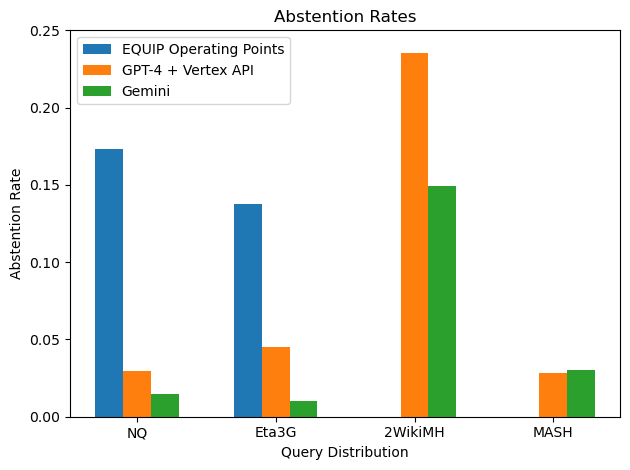

In [25]:
# Sample data
datasets = ['NQ', 'Eta3G', '2WikiMH', 'MASH']

methods = ['EQUIP Operating Points', 'GPT-4 + Vertex API', 'Gemini']

# Sample abstention rates for each method over each dataset
abstention_rates = np.array([
    abstention_rates_by_dataset['NQ'],  # Dataset 1
    abstention_rates_by_dataset['Eta3G'], # Dataset 2
    abstention_rates_by_dataset['MH'],  # Dataset 3
    abstention_rates_by_dataset['MASH']   # Dataset 4
])

# Set up the bar positions
x = np.arange(len(datasets))  # the label locations
width = 0.2  # the width of the bars

# Create the bar plots
fig, ax = plt.subplots()
bars1 = ax.bar(x - width, abstention_rates[:, 0], width, label=methods[0])
bars2 = ax.bar(x, abstention_rates[:, 1], width, label=methods[1])
bars3 = ax.bar(x + width, abstention_rates[:, 2], width, label=methods[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Query Distribution')
ax.set_ylabel('Abstention Rate')
ax.set_title('Abstention Rates')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()
plt.ylim([0,.25])
# Show the plot
plt.tight_layout()
plt.savefig('../visualize_results/figures/abstentions_by_method_qd.png', bbox_inches='tight', dpi=400)

plt.show()


# Abstention rates by failure type

In [26]:
# Get the abstention rate per method over all datasets
# This isn't very meaningful because Snippet-Abstractive have access to gold sources, unlike Gemini
# first, concatenate everything
all_op_generation_results = pd.DataFrame()
all_baseline_generation_results = pd.DataFrame()
retrieval_failure_rates_by_dataset = {}
generation_failure_rates_by_dataset = {}
for k in dataset_str_ls:
    all_ops = op_original_generations_with_failures[k]
    # all_op_generation_results = pd.concat([all_op_generation_results, op_original_generations_with_failures[k]])
    # all_op_generation_results['data_str'] = k
    gemini = gemini_original_generations_with_failures[k]
    gemini = gemini[gemini['op']!='Quoted']
    # gemini['data_str'] = k
    # # all_baseline_generation_results = pd.concat([all_baseline_generation_results, gemini])
    post_hoc = post_hoc_original_generations_with_failures[k]
    post_hoc = post_hoc[post_hoc['op']!='Quoted']
    # post_hoc['data_str'] = k
    # all_baseline_generation_results = pd.concat([all_baseline_generation_results, post_hoc])

    print(k)
    # Overall snippet-abstractive abstention rate
    retrieval_failure_rates_by_dataset[k] = []
    generation_failure_rates_by_dataset[k] = []
    percent_retrieval_failure = len(all_ops[all_ops['Abstention Type']=='Retrieval Failure'])/len(all_ops)
    percent_generation_failure = len(all_ops[all_ops['Abstention Type']=='Generation Failure'])/len(all_ops)
    retrieval_failure_rates_by_dataset[k].append(percent_retrieval_failure)
    generation_failure_rates_by_dataset[k].append(percent_generation_failure)
    print('OPs:', percent_generation_failure, percent_retrieval_failure)
    
    # Overall Post Hoc abstention rate
    percent_retrieval_failure = len(post_hoc[post_hoc['Abstention Type']=='Retrieval Failure'])/len(post_hoc)
    percent_generation_failure = len(post_hoc[post_hoc['Abstention Type']=='Generation Failure'])/len(post_hoc)
    retrieval_failure_rates_by_dataset[k].append(percent_retrieval_failure)
    generation_failure_rates_by_dataset[k].append(percent_generation_failure)
    print('Post Hoc:', percent_generation_failure, percent_retrieval_failure)

    # Overall Gemini abstention rate
    percent_retrieval_failure = len(gemini[gemini['Abstention Type']=='Retrieval Failure'])/len(gemini)
    percent_generation_failure = len(gemini[gemini['Abstention Type']=='Generation Failure'])/len(gemini)
    retrieval_failure_rates_by_dataset[k].append(percent_retrieval_failure)
    generation_failure_rates_by_dataset[k].append(percent_generation_failure)
    print('Gemini:', percent_generation_failure, percent_retrieval_failure)
    print()

NQ
OPs: 0.05202312138728324 0.12138728323699421
Post Hoc: 0.005 0.01
Gemini: 0.02926829268292683 0.0

Eta3G
OPs: 0.04375 0.09375
Post Hoc: 0.005 0.005
Gemini: 0.045 0.0

MH
OPs: 0.0 0.0
Post Hoc: 0.029850746268656716 0.11940298507462686
Gemini: 0.23529411764705882 0.0

MASH
OPs: 0.0 0.0
Post Hoc: 0.005 0.025
Gemini: 0.02824858757062147 0.0



# Fixed-up plot

{'NQ': [0.05202312138728324, 0.005, 0.02926829268292683], 'Eta3G': [0.04375, 0.005, 0.045], 'MH': [0.0, 0.029850746268656716, 0.23529411764705882], 'MASH': [0.0, 0.005, 0.02824858757062147]}


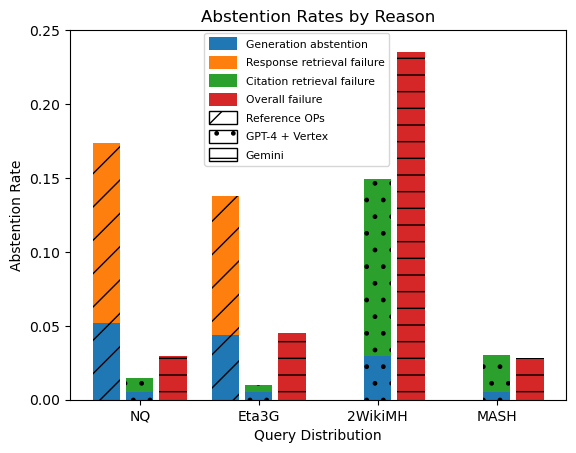

In [27]:
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Patch

bold_font = FontProperties(weight='bold')

# Sample data
datasets = ['NQ', 'Eta3G', '2WikiMH', 'MASH']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]

methods2 = ['Generation Abstention', 'Generation Abstention', 'Overall Failure']
methods1 = ['Response Retrieval Failure', 'Citation Retrieval Failure', 'Overall Failure']
# Sample abstention rates for each method over each dataset
abstention_type1 = np.array([
    generation_failure_rates_by_dataset['NQ'],  # Dataset 1
    generation_failure_rates_by_dataset['Eta3G'], # Dataset 2
    generation_failure_rates_by_dataset['MH'],  # Dataset 3
    generation_failure_rates_by_dataset['MASH']   # Dataset 4
])
print(generation_failure_rates_by_dataset)
abstention_type2 = np.array([
    retrieval_failure_rates_by_dataset['NQ'],  # Dataset 1
    retrieval_failure_rates_by_dataset['Eta3G'], # Dataset 2
    retrieval_failure_rates_by_dataset['MH'],  # Dataset 3
    retrieval_failure_rates_by_dataset['MASH']   # Dataset 4
])

# Set up the bar positions
x = np.arange(len(datasets))  # the label locations
width = 0.23  # the width of the bars

# Create the bar plots
fig, ax = plt.subplots()
# Stacked bars
bars1 = ax.bar(x - width-0.05, abstention_type1[:, 0],  width, label='Generation Abstention', color='tab:blue', hatch=patterns[0])
bars2 = ax.bar(x - width-0.05, abstention_type2[:, 0], width, bottom=abstention_type1[:, 0], label='Response Retrieval Failure', color='tab:orange', hatch=patterns[0])

bars3 = ax.bar(x, abstention_type1[:, 1], width, label='Generation Abstention', color='tab:blue', hatch=patterns[8])
bars4 = ax.bar(x, abstention_type2[:, 1], width, bottom=abstention_type1[:, 1], label='Citation Retrieval Failure', color='tab:green', hatch=patterns[8])

bars5 = ax.bar(x + width+0.05, abstention_type1[:, 2], width, label='Overall Failure', color='tab:red', hatch=patterns[3])
# bars6 = ax.bar(x + width, abstention_type2[:, 2], width, bottom=abstention_type1[:, 2], label='Overall Failure', color='tab:red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Query Distribution')
ax.set_ylabel('Abstention Rate')
ax.set_title('Abstention Rates by Reason')
ax.set_xticks(x)
ax.set_xticklabels(datasets)

custom_handles = [
    Patch(facecolor='tab:blue', label='Generation abstention'),
    Patch(facecolor='tab:orange', label='Response retrieval failure'),
    Patch(facecolor='tab:green', label='Citation retrieval failure'),
    Patch(facecolor='tab:red', label='Overall failure'),
    Patch(facecolor='white', edgecolor='black', hatch=patterns[0], label='Reference OPs'),
    Patch(facecolor='white', edgecolor='black', hatch=patterns[8], label='GPT-4 + Vertex'),
    Patch(facecolor='white', edgecolor='black', hatch=patterns[3], label='Gemini'),
]
ax.legend(handles = custom_handles,
          bbox_to_anchor=(.653,1.007), 
          prop={'size': 7.8},
          handleheight=1.48, 
          handlelength=2.6)

plt.ylim(0, .25)
plt.savefig('../visualize_results/figures/abstentions_by_method_qd_failure_type.png', bbox_inches='tight', dpi=400)
plt.show()


In [28]:
generation_failure_rates_by_dataset

{'NQ': [0.05202312138728324, 0.005, 0.02926829268292683],
 'Eta3G': [0.04375, 0.005, 0.045],
 'MH': [0.0, 0.029850746268656716, 0.23529411764705882],
 'MASH': [0.0, 0.005, 0.02824858757062147]}